In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## PolyA gene transcript detection

What fraction of polyA genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [2]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [3]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [4]:
gene_df, _, _ = get_gtf_info(how='gene')

polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} annotated polyA genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_polya, n_polya))

Detected 24936 / 49472 annotated polyA genes w/ at least 1 known transcript >= 1 TPM


## Characteristics of detected known, polyA gene associated transcripts

Number of cell types or tissues that each known transcript from polyA genes is expressed >= 1 TPM

In [6]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [7]:
df = df.transpose()
df.index.name = 'dataset'
df.reset_index(inplace=True)

# add biosample name (ie without rep information)
df['biosample'] = df.dataset.str.rsplit('_', n=2, expand=True)[0]
df.drop(['dataset'], axis=1, inplace=True)

# record the highest TPM value per biosample
tissue_df = get_tissue_metadata()
tissue_df = tissue_df[['tissue', 'biosample']]

df = df.merge(tissue_df, how='left', on='biosample')
df.loc[df.tissue.isnull(), 'tissue'] = df.loc[df.tissue.isnull(), 'biosample']
df.drop('biosample', axis=1, inplace=True)
df.rename({'tissue': 'biosample'}, axis=1, inplace=True)

df = df.groupby('biosample').max()

# finally, calculate the number of biosamples these transcripts
# are expressed >= 1 TPM
df = df.transpose()
df['n_samples'] = (df >= 1).astype(int).sum(axis=1)

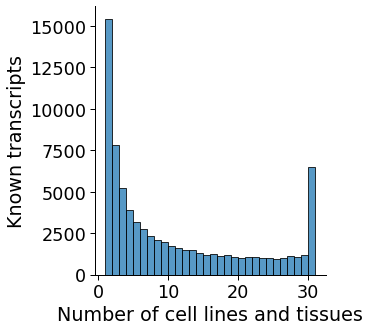

In [8]:
opref = 'figures/'

sns.set_context('paper', font_scale=2)

ax = sns.displot(data=df, x='n_samples', kind='hist', binwidth=1)
# ax = sns.displot(data=temp, x='length', kind='kde', 
#                  linewidth=3)

xlabel = 'Number of cell lines and tissues'
ylabel = 'Known transcripts'
# _ = ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0,10000))
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

plt.savefig('{}_iso_det_1_tpm_biosample.pdf'.format(opref), \
            dpi=300, bbox_inches='tight')

Length of transcripts from polyA genes detected >= 1 TPM

In [9]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [10]:
# merge with transcript len
t_df, _, _ = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

KeyError: "['gid'] not in index"

In [ ]:
opref = 'figures/'

sns.set_context('paper', font_scale=2)

ax = sns.displot(data=df, x='t_len', kind='hist')
# ax = sns.displot(data=temp, x='length', kind='kde', 
#                  linewidth=3)

xlabel = 'Transcript length'
ylabel = 'Known transcripts'
_ = ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0,10000))
# _ = ax.set(xlabel=xlabel, ylabel=ylabel)

plt.savefig('{}_iso_det_1_tpm_length.pdf'.format(opref), \
            dpi=300, bbox_inches='tight')

Variance in TPM levels >= 1 TPM for known transcripts detected >= 1 TPM

In [41]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polyA genes
Enforcing minimum TPM
Total # isos detected: 85348
# isos >= 1 tpm: 77128
Subsetting on polya genes
Number of isos reported: 74796


In [42]:
df.head()

,gm12878_1_1,gm12878_1_2,gm12878_1_3,gm12878_1_4,gm12878_3_1,gm12878_2_1,gm12878_2_2,pgp1_1_1,pgp1_1_2,h9_1_1,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
annot_transcript_id,,,,,,,,,,,,,,,,,,,,,
ENST00000469289.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000417324.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.737626,1.618796,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000461467.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.737626,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000442987.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENST00000494149.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.737626,6.475185,1.242064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
